In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
import keras
import keras.backend as K
import click
import logging
import csv

from tensorflow.keras import datasets, layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc

#define parameters
BATCH_SIZE = 8
IMG_SIZE = (224, 224)
bs = BATCH_SIZE - 1

dPATH=os.getcwd()




all_dir2 = os.path.join(dPATH, 'datasets/091810021113')

all_dataset = image_dataset_from_directory(all_dir2,
                                                  shuffle=False,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)
 
class_names = all_dataset.class_names
mPATH = "saved_models"
rPATH = "VideoResultsUnshuffled"

print(class_names)





Found 5739 files belonging to 3 classes.
['nerve', 'opening wound', 'tendon']


In [2]:
def eva(Mname, nos):
    z=os.path.join(mPATH, Mname, nos)
    z1=os.path.join(rPATH, Mname+nos, Mname+nos+"_CM.txt")
    z2=os.path.join(rPATH, Mname+nos, Mname+nos+"_F1.txt")
    z3=os.path.join(rPATH, Mname+nos, Mname+nos+"_AUC.txt")
    z4=os.path.join(rPATH, Mname+nos, Mname+nos+"_roc.png")
    model = tf.keras.models.load_model(z)
    print("Generate predictions for all data for {}" .format(Mname+nos))
    ##############################
    prediction_score_for_ROC = []
    prediction_label_for_ROC = []
    prediction_flattened=[]
    prediction_true_label=[]
    
    all_dataset_iterator =  all_dataset.as_numpy_iterator()
    
    for k in range(tf.data.experimental.cardinality(all_dataset)):
        image_batch, label_batch = all_dataset_iterator.next()
        predictions = model.predict_on_batch(image_batch)
        prediction_true_label = [*prediction_true_label,*label_batch]
        #print("prediction_true_label:",prediction_true_label)
        for i in range(len(predictions)):
            _zeroArray = np.zeros(3)
            _zeroArray[label_batch[i]] = 1
            prediction_label_for_ROC.append(_zeroArray)
            predictions_softmax = tf.nn.softmax(predictions)
            prediction_score_for_ROC.append(predictions_softmax[i])
            #print("index:{}, array:{}, max index:{}".format(i,predictions[i],np.argmax(predictions[i])))
            prediction_flattened.append( np.argmax(predictions[i]))
            ######modify here
            if i == bs:
                if label_batch[bs] != np.argmax(predictions[bs]):
                    tfs = "Wrong"
                else:
                    tfs = "Correct"
                title =  tfs +": True class:"+class_names[label_batch[bs]]+" ,Predicted class:"+class_names[np.argmax(predictions[bs])]
                PN = os.path.join(rPATH, Mname+nos, Mname+nos+tfs+class_names[label_batch[bs]]+class_names[np.argmax(predictions[bs])]+str(k)+str(bs)+".png")
                plt.imshow(image_batch[bs].astype("uint8"))
                plt.title(title)
                plt.axis("off")
                plt.savefig(PN)
                print("Finished predicting {}batches({}images)" .format(k, k*BATCH_SIZE))
            #if label_batch[i] != np.argmax(predictions[i]):
                #title = "True class:"+class_names[label_batch[i]]+" ,Predicted class:"+class_names[np.argmax(predictions[i])]
                #PN = os.path.join(rPATH, Mname+nos, Mname+nos+"False"+class_names[label_batch[i]]+class_names[np.argmax(predictions[i])]+str(k)+str(i)+".png")
                #plt.imshow(image_batch[i].astype("uint8"))
                #plt.title(title)
                #plt.axis("off") 
                #plt.savefig(PN)
    
    
    predictionsA = np.array(prediction_flattened)
    prediction_true_label = np.array(prediction_true_label)
    prediction_score_for_ROC = np.array(prediction_score_for_ROC)
    prediction_label_for_ROC = np.array(prediction_label_for_ROC)
    s = open(z1, 'a')
    print(tf.math.confusion_matrix(prediction_true_label, predictionsA), file=s)
    s.close()
    q = open(z2, 'a')
    import sklearn
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    print('\nAccuracy: {:.4f}\n'.format(accuracy_score(prediction_true_label, predictionsA)), file=q)
    
    print('Micro Precision: {:.4f}'.format(precision_score(prediction_true_label, predictionsA, average='micro')), file=q)
    print('Micro Recall: {:.4f}'.format(recall_score(prediction_true_label, predictionsA, average='micro')), file=q)
    print('Micro F1-score: {:.4f}\n'.format(f1_score(prediction_true_label, predictionsA, average='micro')), file=q)
    
    print('Macro Precision: {:.4f}'.format(precision_score(prediction_true_label, predictionsA, average='macro')), file=q)
    print('Macro Recall: {:.4f}'.format(recall_score(prediction_true_label, predictionsA, average='macro')), file=q)
    print('Macro F1-score: {:.4f}\n'.format(f1_score(prediction_true_label, predictionsA, average='macro')), file=q)
    
    print('Weighted Precision: {:.4f}'.format(precision_score(prediction_true_label, predictionsA, average='weighted')), file=q)
    print('Weighted Recall: {:.4f}'.format(recall_score(prediction_true_label, predictionsA, average='weighted')), file=q)
    print('Weighted F1-score: {:.4f}'.format(f1_score(prediction_true_label, predictionsA, average='weighted')), file=q)
    
    from sklearn.metrics import classification_report
    print('\nClassification Report\n', file=q)
    print(classification_report(prediction_true_label, predictionsA, target_names=['nerve', 'opening wound', 'tendon']), file=q)
    
    from sklearn.metrics import multilabel_confusion_matrix
    from sklearn.metrics import matthews_corrcoef
    MCC = matthews_corrcoef(prediction_true_label, predictionsA)
    print("Matthew's coefficient is: ", file=q)
    print(MCC, file=q)
    print("	", file=q)
    mcm = multilabel_confusion_matrix(prediction_true_label, predictionsA)
    #print("mcm is: \n", file=q)
    #print(mcm, file=q)
    tn = mcm[:, 0, 0]
    tp = mcm[:, 1, 1]
    fn = mcm[:, 1, 0]
    fp = mcm[:, 0, 1]
    print("True positive:", file=q)
    print(tp, file=q)
    print("	", file=q)
    print("True negative:", file=q)
    print(tn, file=q)
    print("	", file=q)
    print("False positive:", file=q)
    print(fp, file=q)
    print("	", file=q)
    print("False negative:", file=q)
    print(fn, file=q)
    sensitivity = tp / (tp + fn)
    precision = tp / (tp + fp)
    specificity = tn / (tn + fp)
    NPV = tn / (tn + fn)
    accuracy3 = (tp + tn)/ (tp + fp + tn + fn)
    
    from math import sqrt
    print("Per class Matthews coefficient:	", file=q)
    for i in [0,1,2]:
        MCC1 = (tp[i]*tn[i] - fp[i]*fn[i])/sqrt((tp[i]+fp[i])*(tp[i]+fn[i])*(tn[i]+fp[i])*(tn[i]+fn[i]))
        print(MCC1, file=q)
    print("	", file=q)
    
    print("\n", file=q)
    print("nerve	opening wound	tendon\n", file=q)
    print("Sensitivity, hit rate, recall, or true positive rate:	", file=q)
    print(sensitivity, file=q)
    print("	", file=q)
    print("Specificity or true negative rate:	", file=q)
    print(specificity, file=q)
    print("	", file=q)
    print("precision or positive predictive value:	", file=q)
    print(precision, file=q)
    print("	", file=q)
    print("Negative predictive value:	", file=q)
    print(NPV, file=q)
    print("	", file=q)
    print("Accuracy:	", file=q)
    print(accuracy3, file=q)
    print("	", file=q)
    F1P = []
    for i in [0,1,2]:
        F1P.append((2*precision[i]*sensitivity[i])/(precision[i]+sensitivity[i]))
    
    F1N = []
    for i in [0,1,2]:
        F1N.append((2*NPV[i]*specificity[i])/(NPV[i]+specificity[i]))
    
    print("F1 score positive(2*precision*specificity)/(precision+sensitivity)", file=q)
    print(F1P, file=q)
    print("	", file=q)
    print("F1 score negative(2*NPV*specificity)/(NPV+specificity)", file=q)
    print(F1N, file=q)
    print("	", file=q)
    print("\n", file=q)
    print("\n", file=q)
    print("Macro average metrics below\n", file=q)
    print("\n", file=q)
    
    Msensitivity=0
    Mspecificity=0
    Mprecision=0
    MNPV=0
    Maccuracy3=0
    MF1P=0
    MF1N=0
    for i in [0,1,2]:
        Msensitivity=Msensitivity+sensitivity[i]
    Msensitivity=Msensitivity/3
    for i in [0,1,2]:
        Mspecificity=Mspecificity+specificity[i]
    Mspecificity=Mspecificity/3
    for i in [0,1,2]:
        Mprecision=Mprecision+precision[i]
    Mprecision=Mprecision/3
    for i in [0,1,2]:
        MNPV=MNPV+NPV[i]
    MNPV=MNPV/3
    for i in [0,1,2]:
        Maccuracy3=Maccuracy3+accuracy3[i]
    Maccuracy3=Maccuracy3/3
    for i in [0,1,2]:
        MF1P=MF1P+F1P[i]
    MF1P=MF1P/3
    for i in [0,1,2]:
        MF1N=MF1N+F1N[i]
    MF1N=MF1N/3
    
    print("	", file=q)
    print("Macro Sensitivity, hit rate, recall, or true positive rate:	", file=q)
    print(Msensitivity, file=q)
    print("	", file=q)
    print("Macro Specificity or true negative rate:	", file=q)
    print(Mspecificity, file=q)
    print("	", file=q)
    print("Macro precision or positive predictive value:	", file=q)
    print(Mprecision, file=q)
    print("	", file=q)
    print("Macro Negative predictive value:	", file=q)
    print(MNPV, file=q)
    print("	", file=q)
    print("Macro Accuracy:	", file=q)
    print(Maccuracy3, file=q)
    print("	", file=q)
    print("Macro F1 score positive(2*precision*specificity)/(precision+sensitivity)", file=q)
    print(MF1P, file=q)
    print("	", file=q)
    print("Macro F1 score negative(2*NPV*specificity)/(NPV+specificity)", file=q)
    print(MF1N, file=q)
    print("	", file=q)
    
    print("\n", file=q)
    print("\n", file=q)
    print("Micro average metrics below\n", file=q)
    print("\n", file=q)
    atp=0
    atn=0
    afp=0
    afn=0
    for i in [0,1,2]:
        atp=atp + tp[i]
    for i in [0,1,2]:
        atn=atn + tn[i]
    for i in [0,1,2]:
        afp=afp + fp[i]	
    for i in [0,1,2]:
        afn=afn + fn[i]
    Asensitivity = atp / (atp + afn)
    Aspecificity = atn / (atn + afp)
    Aprecision = atp / (atp + afp)
    ANPV=atn / (atn + afn)
    Aaccuracy3= (atp + atn)/ (atp + afp + atn + afn)
    AF1P=(2*Aprecision*Asensitivity)/(Aprecision+Asensitivity)
    AF1N=(2*ANPV*Aspecificity)/(ANPV+Aspecificity)
    print("	", file=q)
    print("micro Sensitivity, hit rate, recall, or true positive rate	:\n", file=q)
    print(Asensitivity, file=q)
    print("	", file=q)
    print("micro Specificity or true negative rate:	", file=q)
    print(Aspecificity, file=q)
    print("	", file=q)
    print("micro precision or positive predictive value:	", file=q)
    print(Aprecision, file=q)
    print("	", file=q)
    print("micro Negative predictive value:	", file=q)
    print(ANPV, file=q)
    print("	", file=q)
    print("micro Accuracy:	", file=q)
    print(Aaccuracy3, file=q)
    print("	", file=q)
    print("micro F1 score positive(2*precision*specificity)/(precision+sensitivity):	", file=q)
    print(AF1P, file=q)
    print("	", file=q)
    print("micro F1 score negative(2*NPV*specificity)/(NPV+specificity):	", file=q)
    print(AF1N, file=q)
        
    q.close()
    
#AUC
    import matplotlib
    
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(prediction_label_for_ROC[:, i], prediction_score_for_ROC[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(prediction_label_for_ROC.ravel(), prediction_score_for_ROC.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(3)]))
    
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(3):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    
    # Finally average it and compute AUC
    mean_tpr /= 3
    
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    
    q = open(z3, 'a')
    print(roc_auc, file=q)
        
    q.close()




    # Plot all ROC curves
    from itertools import cycle
    plt.figure(figsize=(16, 16))
    
    fpr["micro"], tpr["micro"], _ = roc_curve(prediction_label_for_ROC.ravel(), prediction_score_for_ROC.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.4f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)
    
    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.4f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)
    
    lw=2
    #class_names=["nerve","open","tendon"]
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(3), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.4f})'
                 ''.format(class_names[i], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.savefig(z4)

    print("Finished evaluating {}" .format(Mname+nos))


Generate predictions for all data for mobileNETv2020
Finished predicting 0batches(0images)
Finished predicting 1batches(8images)
Finished predicting 2batches(16images)
Finished predicting 3batches(24images)
Finished predicting 4batches(32images)
Finished predicting 5batches(40images)
Finished predicting 6batches(48images)
Finished predicting 7batches(56images)
Finished predicting 8batches(64images)
Finished predicting 9batches(72images)
Finished predicting 10batches(80images)
Finished predicting 11batches(88images)
Finished predicting 12batches(96images)
Finished predicting 13batches(104images)
Finished predicting 14batches(112images)
Finished predicting 15batches(120images)
Finished predicting 16batches(128images)
Finished predicting 17batches(136images)
Finished predicting 18batches(144images)
Finished predicting 19batches(152images)
Finished predicting 20batches(160images)
Finished predicting 21batches(168images)
Finished predicting 22batches(176images)
Finished predicting 23batches

Finished predicting 196batches(1568images)
Finished predicting 197batches(1576images)
Finished predicting 198batches(1584images)
Finished predicting 199batches(1592images)
Finished predicting 200batches(1600images)
Finished predicting 201batches(1608images)
Finished predicting 202batches(1616images)
Finished predicting 203batches(1624images)
Finished predicting 204batches(1632images)
Finished predicting 205batches(1640images)
Finished predicting 206batches(1648images)
Finished predicting 207batches(1656images)
Finished predicting 208batches(1664images)
Finished predicting 209batches(1672images)
Finished predicting 210batches(1680images)
Finished predicting 211batches(1688images)
Finished predicting 212batches(1696images)
Finished predicting 213batches(1704images)
Finished predicting 214batches(1712images)
Finished predicting 215batches(1720images)
Finished predicting 216batches(1728images)
Finished predicting 217batches(1736images)
Finished predicting 218batches(1744images)
Finished pr

Finished predicting 387batches(3096images)
Finished predicting 388batches(3104images)
Finished predicting 389batches(3112images)
Finished predicting 390batches(3120images)
Finished predicting 391batches(3128images)
Finished predicting 392batches(3136images)
Finished predicting 393batches(3144images)
Finished predicting 394batches(3152images)
Finished predicting 395batches(3160images)
Finished predicting 396batches(3168images)
Finished predicting 397batches(3176images)
Finished predicting 398batches(3184images)
Finished predicting 399batches(3192images)
Finished predicting 400batches(3200images)
Finished predicting 401batches(3208images)
Finished predicting 402batches(3216images)
Finished predicting 403batches(3224images)
Finished predicting 404batches(3232images)
Finished predicting 405batches(3240images)
Finished predicting 406batches(3248images)
Finished predicting 407batches(3256images)
Finished predicting 408batches(3264images)
Finished predicting 409batches(3272images)
Finished pr

Finished predicting 578batches(4624images)
Finished predicting 579batches(4632images)
Finished predicting 580batches(4640images)
Finished predicting 581batches(4648images)
Finished predicting 582batches(4656images)
Finished predicting 583batches(4664images)
Finished predicting 584batches(4672images)
Finished predicting 585batches(4680images)
Finished predicting 586batches(4688images)
Finished predicting 587batches(4696images)
Finished predicting 588batches(4704images)
Finished predicting 589batches(4712images)
Finished predicting 590batches(4720images)
Finished predicting 591batches(4728images)
Finished predicting 592batches(4736images)
Finished predicting 593batches(4744images)
Finished predicting 594batches(4752images)
Finished predicting 595batches(4760images)
Finished predicting 596batches(4768images)
Finished predicting 597batches(4776images)
Finished predicting 598batches(4784images)
Finished predicting 599batches(4792images)
Finished predicting 600batches(4800images)
Finished pr

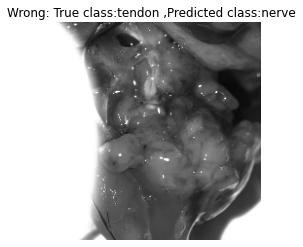

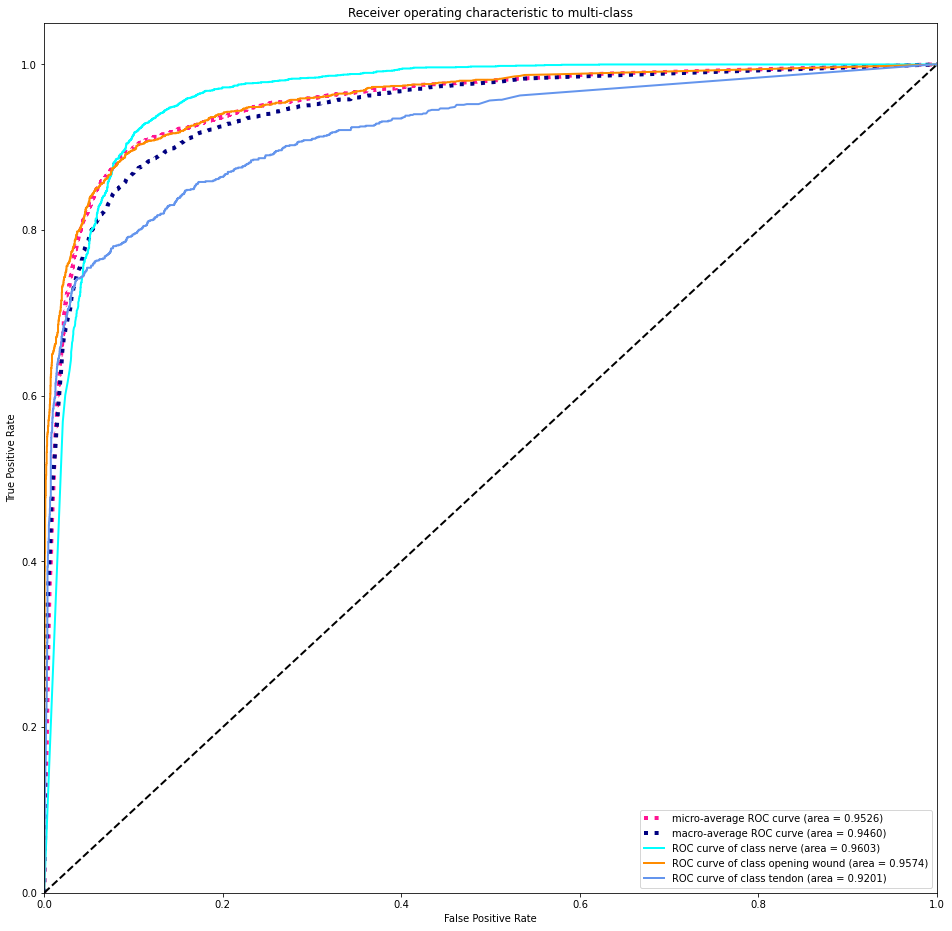

In [3]:
#eva("denseNET121","006")
#eva("denseNET121","007")
#eva("denseNET121","008")
#eva("denseNET121","009")
#eva("denseNET121","010")
#eva("denseNET169","007")
#eva("denseNET169","008")
#eva("denseNET169","009")
#eva("denseNET169","010")
#eva("denseNET169","011")
#eva("denseNET201","006")
#eva("denseNET201","007")
#eva("denseNET201","008")
#eva("denseNET201","009")
#eva("denseNET201","010")
#eva("inceptionV3","006")
#eva("inceptionV3","007")
#eva("inceptionV3","008")
#eva("inceptionV3","009")
#eva("inceptionV3","010")
#eva("mobileNETv2","006")
#eva("mobileNETv2","007")
#eva("mobileNETv2","008")
#eva("mobileNETv2","009")
#eva("mobileNETv2","010")
#eva("nasnet_mobile","011")
#eva("nasnet_mobile","012")
#eva("nasnet_mobile","013")
#eva("nasnet_mobile","014")
#eva("nasnet_mobile","015")
#eva("resnet50v2","011")
#eva("resnet50v2","012")
#eva("resnet50v2","013")
#eva("resnet50v2","014")
#eva("resnet50v2","015")
#eva("resnet101v2","006")
#eva("resnet101v2","007")
#eva("resnet101v2","008")
#eva("resnet101v2","009")
#eva("resnet101v2","010")
#eva("resnet152v2","006")
#eva("resnet152v2","007")
#eva("resnet152v2","008")
#eva("resnet152v2","010")
#eva("resnet152v2","011")
#############################trained with dataset 101611271211##########
#eva("resnet50v2","016")
#eva("resnet101v2","011")
#eva("resnet152v2","012")
#eva("denseNET169","012")
#eva("denseNET201","011")


#eva("resnet50v2","017")
#eva("resnet50v2","018")
#eva("resnet50v2","019")
#eva("resnet50v2","020")
#eva("resnet101v2","012")
#eva("resnet101v2","013")
#eva("resnet101v2","014")
#eva("resnet101v2","015")
#eva("denseNET169","013")
#eva("denseNET169","014")
#eva("denseNET169","015")
#eva("denseNET169","016")
#eva("denseNET201","012")
#eva("denseNET201","013")
#eva("denseNET201","014")
#eva("denseNET201","015")
#eva("mobileNETv2","011")
#eva("mobileNETv2","012")
#eva("mobileNETv2","013")
#eva("mobileNETv2","014")
#eva("mobileNETv2","015")

########################evaluating shuffle trained NN#######################

#eva("resnet50v2","021")
#eva("resnet50v2","022")
#eva("resnet50v2","023")
#eva("resnet50v2","024")
#eva("resnet50v2","025")
#eva("resnet101v2","016")
#eva("resnet101v2","017")
#eva("resnet101v2","018")
#eva("resnet101v2","019")
#eva("resnet101v2","020")
#eva("resnet101v2","021")
#eva("resnet101v2","022")
#eva("denseNET169","017")
#eva("denseNET169","018")
#eva("denseNET169","019")
#eva("denseNET169","020")
#eva("denseNET169","021")
#eva("denseNET201","016")
#eva("denseNET201","017")
#eva("denseNET201","018")
#eva("denseNET201","019")
#eva("denseNET201","020")
#eva("mobileNETv2","016")
#eva("mobileNETv2","017")
#eva("mobileNETv2","018")
#eva("mobileNETv2","019")
eva("mobileNETv2","020")




################Augmented#################
#eva("denseNET201","021")
#eva("denseNET201","022")

